# Uniform Distribution of Samples in the Search Space 

A current problem we may encounter is that even though we investigate the user-space as a uniformly distributed space. However, when mapping the user-space into the CLIP-Space, this uniform distribution does not hold and therefore requires adaptation to ensure an even search through the user-space. At first, we visualize the problem.

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

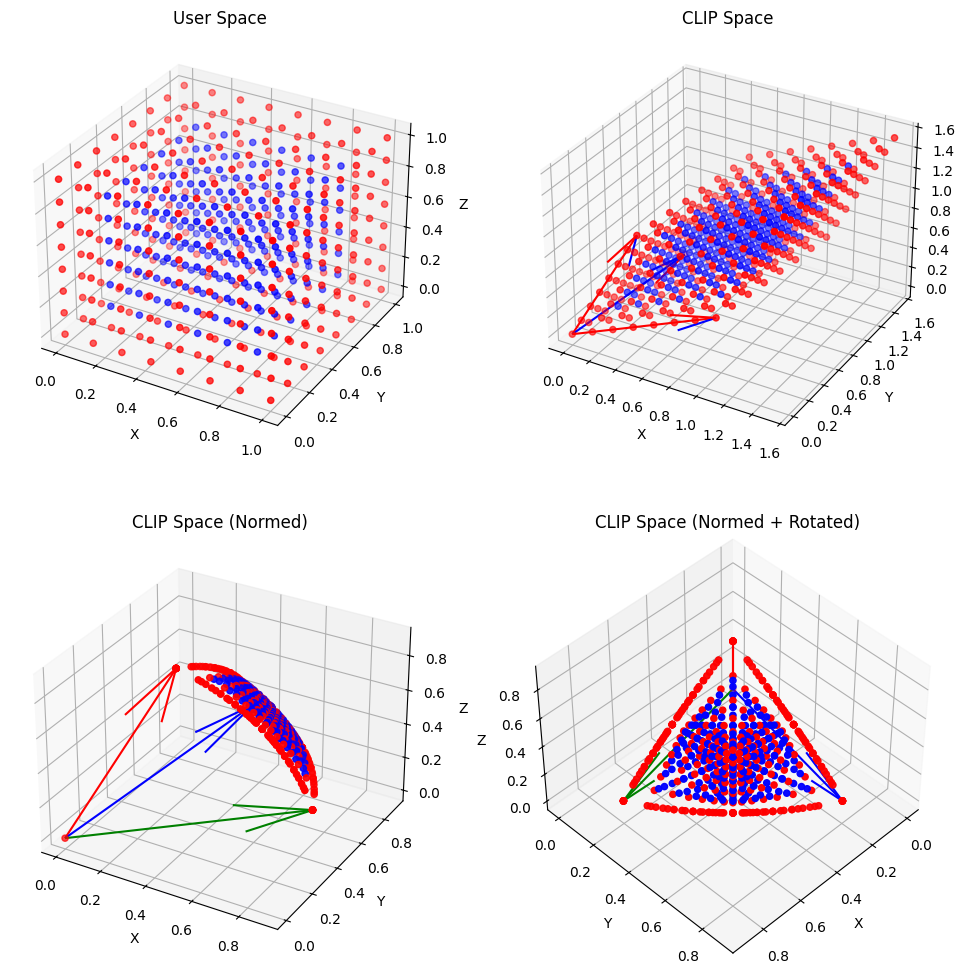

In [3]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate a mesh grid in the user space
# Parameters
num_points = 8  # Number of points along each axis
x_min, x_max = .0, 1.0  # Range for the x-axis
y_min, y_max = .0, 1.0  # Range for the y-axis
z_min, z_max = .0, 1.0  # Range for the y-axis

# Generate evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points)
y = torch.linspace(y_min, y_max, num_points)
z = torch.linspace(z_min, z_max, num_points)

# Create a grid of 2D points
x_grid, y_grid, z_grid = torch.meshgrid(x, y, z)

# Flatten the grid to get the coordinates
x_rand = torch.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], dim=1)

colors = []
for p in x_rand:
    if 0. in p or 1. in p:
        colors.append('red')
    else:
        colors.append('blue')

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2], c=colors)
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b', 'g'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=colors)
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b', 'g'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2], c=colors)
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b', 'g'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2], c=colors)
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

# Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Problem Setting

As we can observe, the evenly spaced meshgrid in the user-space does not allow for an evenly spaced search in the CLIP Space, as well as a lot of points mapping to a similar space. The same goes for random sampling in the user-space as can be seen subsequently.

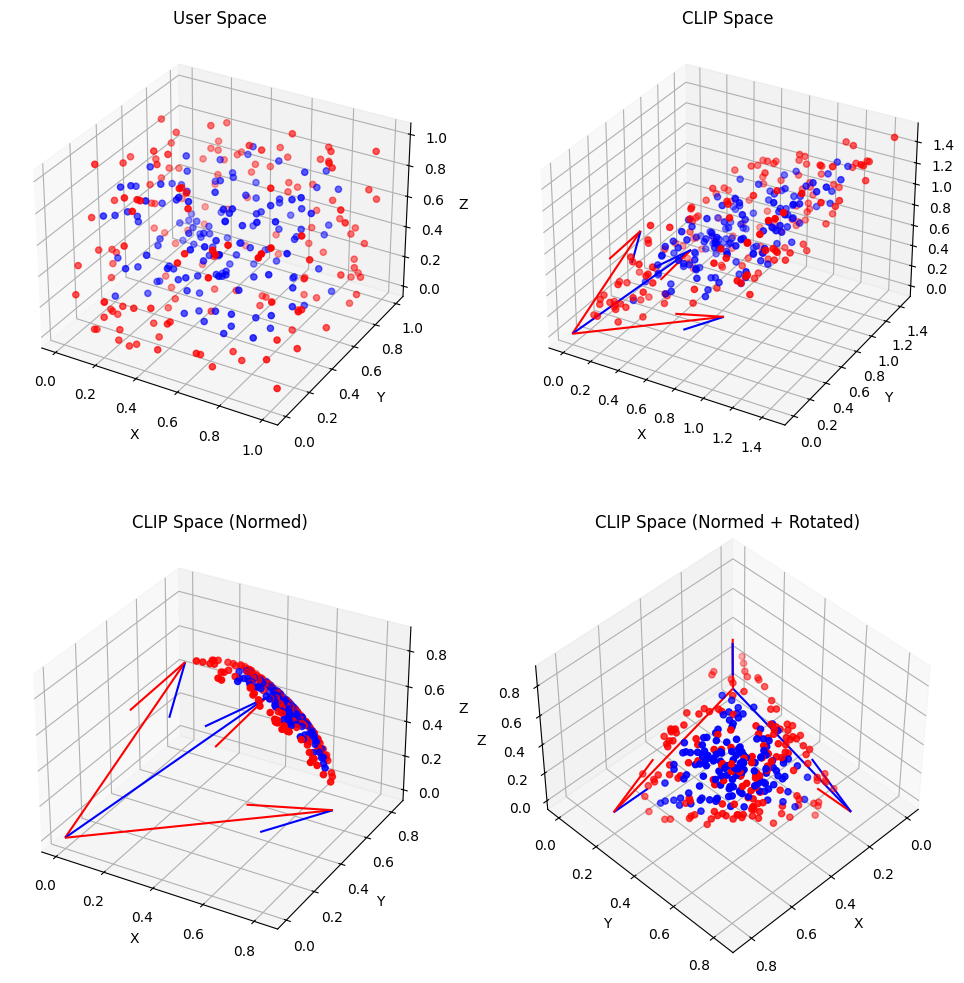

In [10]:
torch.manual_seed(42)

# Flatten the grid to get the coordinates
x_rand = torch.rand(size=(300, 3))

colors = []
for p in x_rand:
    if True in (p > 0.9) or True in (p < 0.1):
        colors.append('red')
    else:
        colors.append('blue')

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2], c=colors)
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=colors)
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2], c=colors)
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2], c=colors)
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Problem

While random does not have the same "empty spaces" as the meshgrid, we can see that the corners are more or less ignored in the CLIP Space. We therefore need to find a solution to generate points in the user-space that transform into an uniform distribution in the clip space.

# Solution

Our basic implication we work on is the following: 

    Given two vectors a, b of equal length, |a| == |b| and two factors x,y \in [0, 1], the following equation holds:

        |x*a + y*b| == |a| == |b|

    This in addition with randomness may already provide a solution, so lets see!

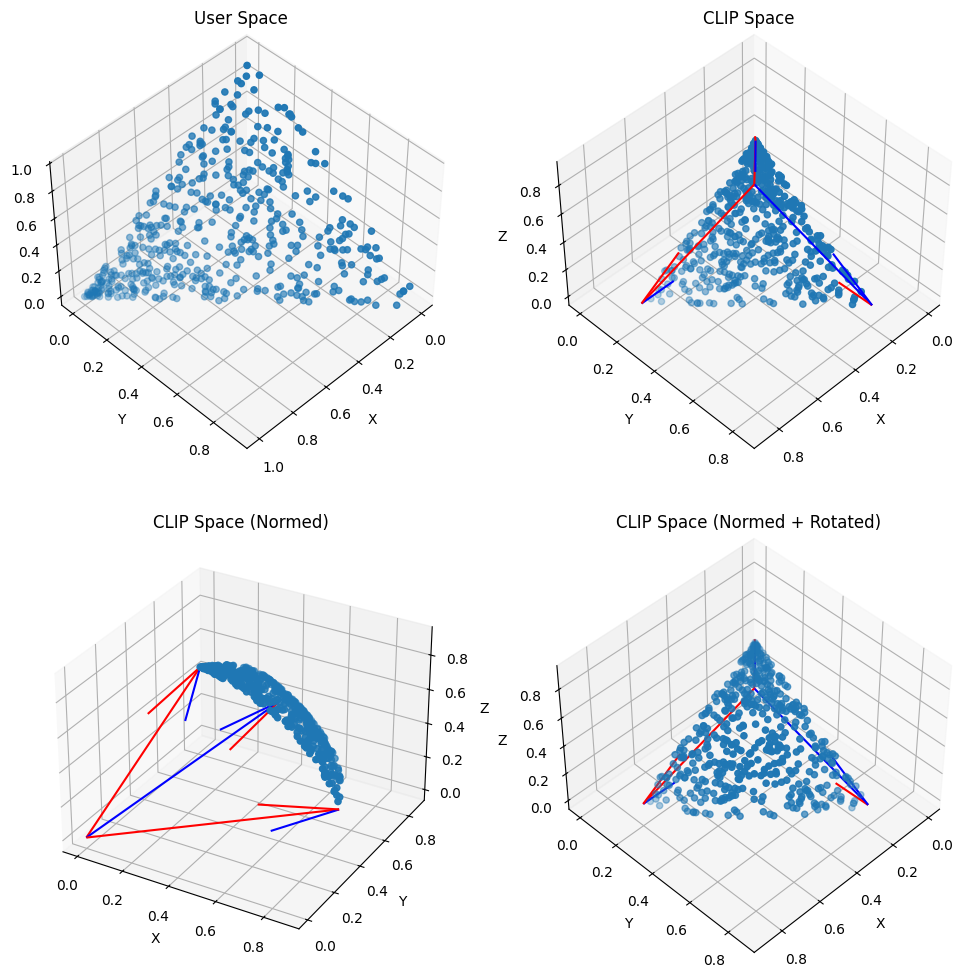

In [12]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
n_samples = 500
x_rand = torch.rand(size=(n_samples, 1))
y_rand = torch.rand(size=(n_samples, 1)) * (1-x_rand)
z_rand = 1 - (x_rand + y_rand)
x_rand = torch.cat((x_rand, y_rand, z_rand), dim=1)

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)
ax_0.view_init(elev, azim, roll)
ax_1.view_init(elev, azim, roll)

plt.show()

# Second Idea
Mesh Grid but only the ones that sum up to 1

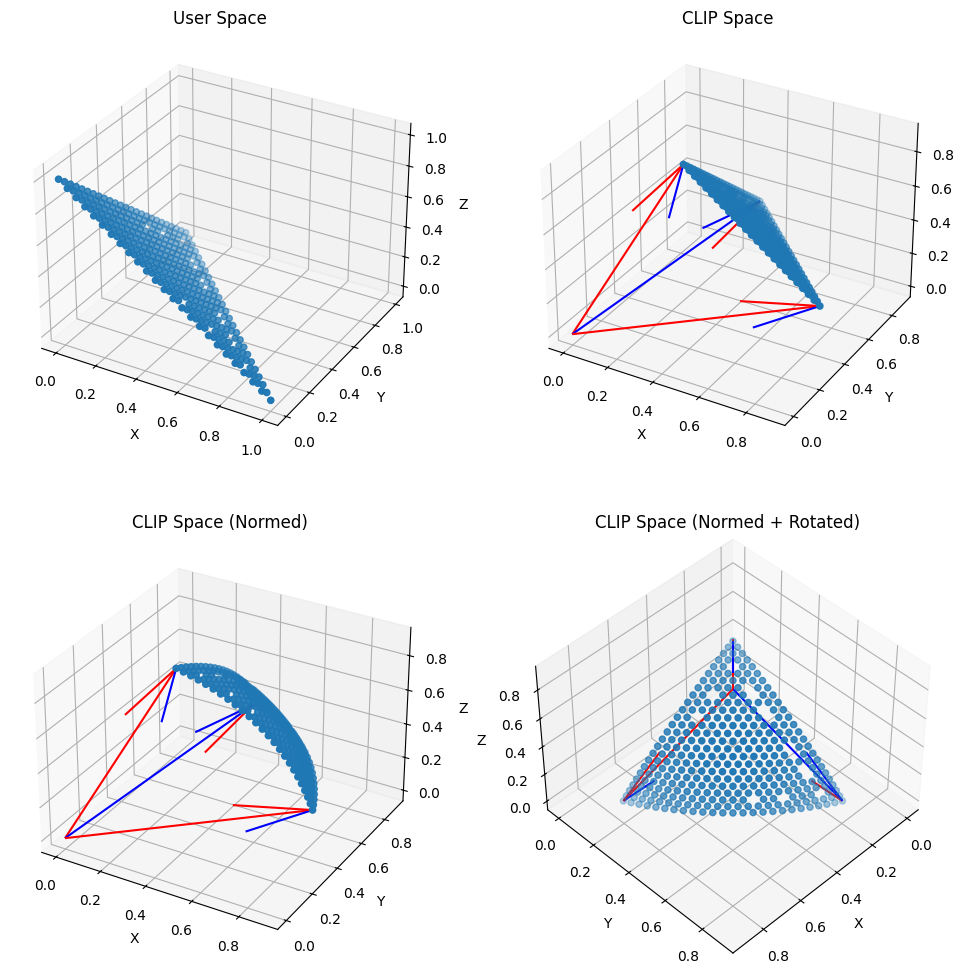

In [6]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate random samples in the user space
# x_rand = torch.rand(size=(500, 3))

# Generate a mesh grid in the user space
# Parameters
num_points = 25  # Number of points along each axis
x_min, x_max = .0, 1.0  # Range for the x-axis
y_min, y_max = .0, 1.0  # Range for the y-axis
z_min, z_max = .0, 1.0  # Range for the y-axis

# Generate evenly spaced points along x and y axes
x = torch.linspace(x_min, x_max, num_points)
y = torch.linspace(y_min, y_max, num_points)
z = torch.linspace(z_min, z_max, num_points)

# Create a grid of 2D points
x_grid, y_grid, z_grid = torch.meshgrid(x, y, z)

# Flatten the grid to get the coordinates
x_rand = torch.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()], dim=1)

# Filter Datapoints that have a sum lower 1.5
x_rand = x_rand[x_rand.sum(dim=1) == 1.]

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Third Idea

Sample vectors with length 1 by using the Dirichlet Distribution.

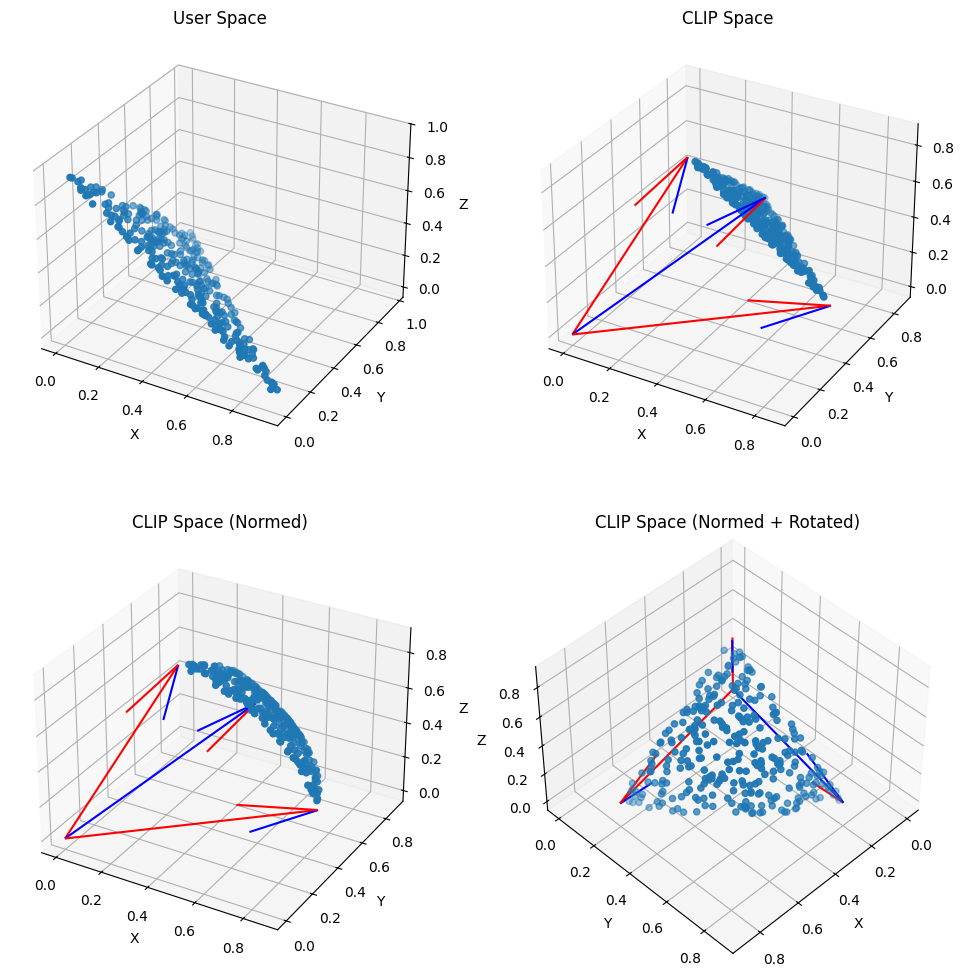

In [7]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Generate samples from the Dirichlet distribution
num_samples = (3) * 100
alpha = torch.ones(3)  # Concentration parameter (uniform)
distribution = torch.distributions.dirichlet.Dirichlet(alpha)
x_rand = distribution.sample(sample_shape=(num_samples,))

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Fourth Idea

Make a meshgrid again, but calculate the last coordinate to make it sum up to 1 instead of calculating a huge meshgrid and filtering the ones that sum up to 1.

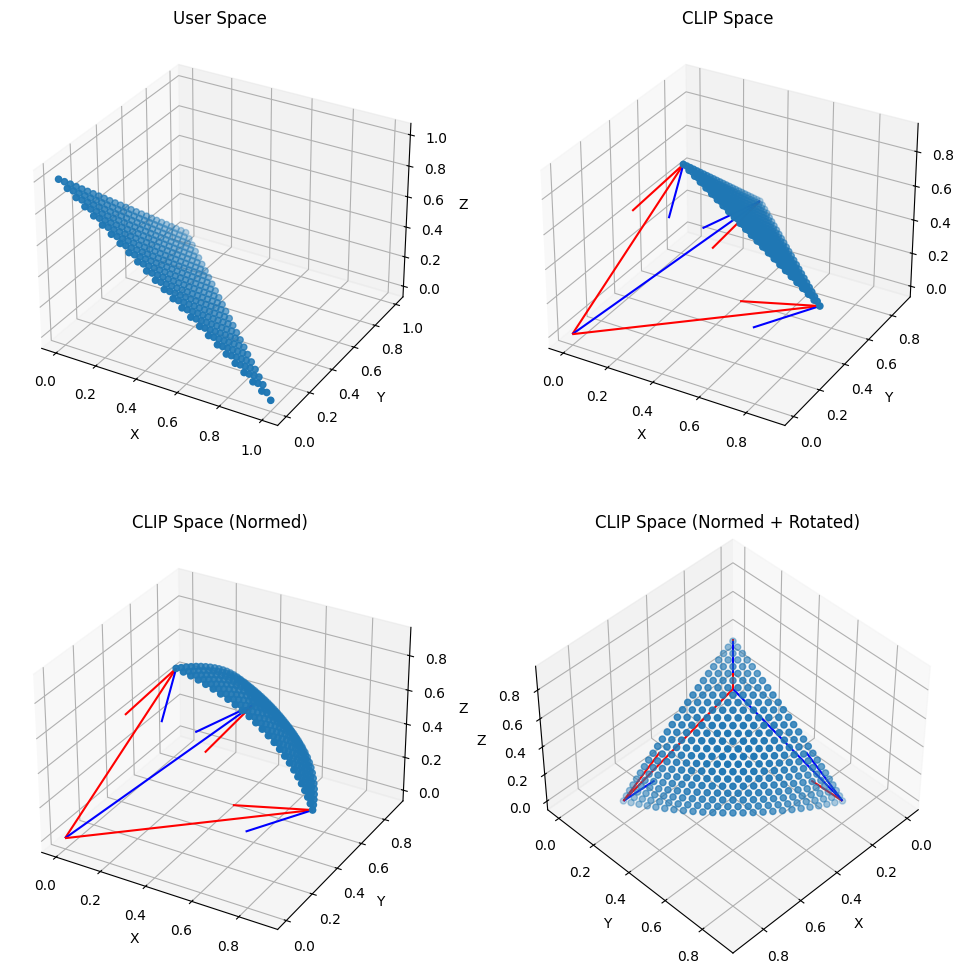

In [8]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Parameters
num_samples = 25  # Number of samples along one axis (this will give a resolution)

# Generate 2D grid of points (x, y) in the range [0, 1]
x = torch.linspace(0, 1, num_samples)
y = torch.linspace(0, 1, num_samples)

# Create meshgrid of points
x_grid, y_grid = torch.meshgrid(x, y)

# Mask out the points where x + y > 1 to ensure they lie on the plane x + y + z = 1
mask = (x_grid + y_grid) <= 1

# Get the corresponding z values
z_grid = 1 - x_grid - y_grid

# Apply the mask to filter out points outside the region x + y <= 1
x_grid = x_grid[mask]
y_grid = y_grid[mask]
z_grid = z_grid[mask]

x_rand = torch.cat((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1), z_grid.reshape(-1, 1)), dim=1)

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# SinglePointRecommender

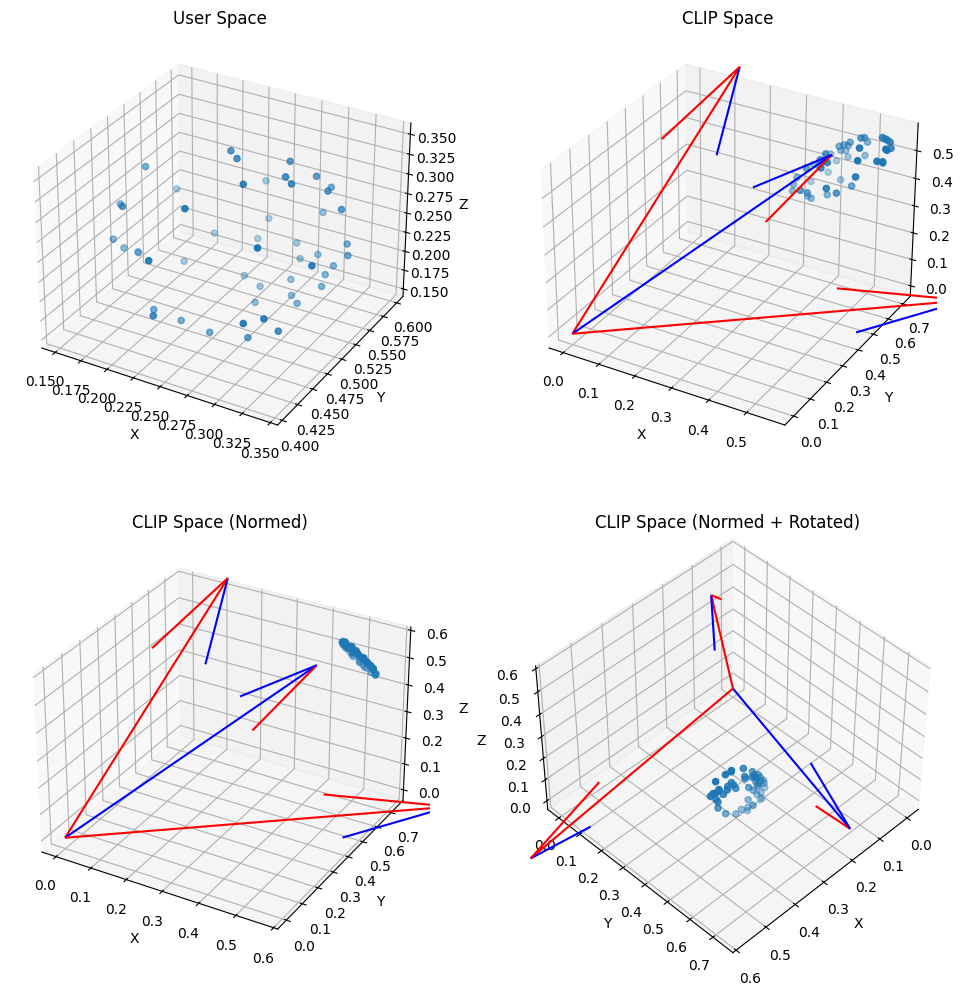

In [9]:
import torch.nn.functional as F
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42)

# Define vectors
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])  # origin point
heads = torch.tensor([[0.35, 0.35, 1.0], [0.35, 1.0, 0.35], [1.0, 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Parameters
num_samples = 50  # Resolution along one axis
radius = 0.1
n_dims = 3
user_profile = torch.tensor([[0.25, 0.5, 0.25]])

x = np.random.default_rng().normal(size=(num_samples, n_dims))
x_rand = torch.from_numpy(radius / np.sqrt(np.sum(x ** 2, 1, keepdims=True)) * x).float()
x_rand = torch.add(x_rand, user_profile)

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

The SinglePoint Recommender seems to work well, since it is supposed to recommend points around a (high confidence) user profile. 
However, if the user profile is bad or the user wants to explore the space,this recommender is not suitable.
Anyhow, the SinglePointRecommender can be used to recommend points around a user profile and thus, won't be discarded or extended to cooperate uniform sphere distribution.

# SinglePointWeightedAxesRecommender

torch.Size([2, 3]) torch.Size([3]) torch.Size([3])


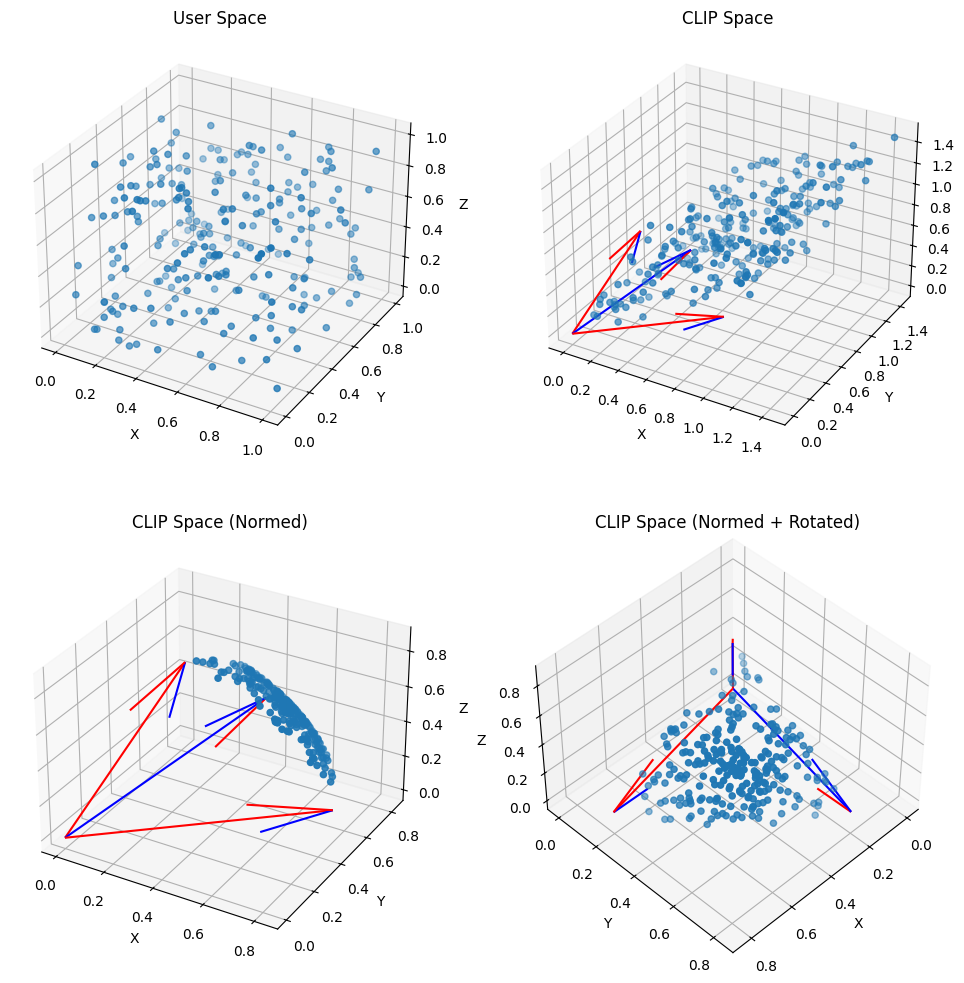

In [10]:
torch.manual_seed(42)

# Define three Vectors defining the User Space in the CLIP space
origin = torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]) # origin point
heads = torch.tensor([[0.35, 0.35, 1.], [0.35, 1., 0.35], [1., 0.35, 0.35]])
heads_normed = F.normalize(heads, p=2, dim=-1)

# Parameters
num_samples = 250  # Number of samples along one axis (this will give a resolution)
exploration_factor = 1.0
bounds = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])
user_profile = torch.tensor([0.25, 0.5, 0.25])

axes = torch.eye(user_profile.shape[0])

print(bounds.shape, user_profile.shape, bounds[0].shape)

# distance of embedding bounds to user profile to find range to sample from
lower_sampling_ranges = bounds[0] - user_profile
upper_sampling_ranges = bounds[1] - user_profile

# random weights for axes for each recommendation in bounds
weights = torch.rand(size=(num_samples, user_profile.shape[0]))  # in [0, 1]
# scale to bounds to ranges & scale with exploration factor
weights = (exploration_factor *
           (weights * (upper_sampling_ranges - lower_sampling_ranges) + lower_sampling_ranges))

# interpolate between user profile and axes, user user_profile as reference point
x_rand = user_profile + weights @ axes

# Plot the samples in the user space
fig = plt.figure(figsize=(12, 12))
ax_0 = fig.add_subplot(2, 2, 1, projection='3d')
ax_0.scatter(x_rand[:,0], x_rand[:,1], x_rand[:, 2])
ax_0.set_title('User Space')
ax_0.set_xlabel('X')
ax_0.set_ylabel('Y')
ax_0.set_zlabel('Z')

# Plot random samples transformed into the CLIP space
embeds =  x_rand @ heads_normed
ax_1 = fig.add_subplot(2, 2, 2, projection='3d')
ax_1.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_1.scatter(embeds[:,0], embeds[:,1], embeds[:,2])
ax_1.set_title('CLIP Space')
ax_1.set_xlabel('X')
ax_1.set_ylabel('Y')
ax_1.set_zlabel('Z')

# Project embeds on the spheres surface in the CLIP Space
embeds_proj = F.normalize(embeds, p=2, dim=-1)
ax_2 = fig.add_subplot(2, 2, 3, projection='3d')
ax_2.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_2.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_2.set_title('CLIP Space (Normed)')
ax_2.set_xlabel('X')
ax_2.set_ylabel('Y')
ax_2.set_zlabel('Z')

# Same PLot but with a front view
ax_3 = fig.add_subplot(2, 2, 4, projection='3d')
ax_3.quiver(*origin, heads_normed[:,0], heads_normed[:,1], heads_normed[:,2], color=['r','b'])
ax_3.scatter(embeds_proj[:,0], embeds_proj[:,1], embeds_proj[:,2])
ax_3.set_title('CLIP Space (Normed + Rotated)')
ax_3.set_xlabel('X')
ax_3.set_ylabel('Y')
ax_3.set_zlabel('Z')

#Rotate to se the sphere
angle = 90
angle_norm = (angle + 180) % 360 - 180
elev = 45
azim = 45
roll = 0
ax_3.view_init(elev, azim, roll)

plt.show()

# Mask approach

In [11]:
n_points_per_axis = 5
embedding_bounds = [0., 1.]
latent_bounds = [0., 1.]
n_embedding_axis = 2
n_latent_axis = 2

# Build search space and filter for embeddings that are on a sphere in CLIP space
x_embed = torch.linspace(embedding_bounds[0], embedding_bounds[1], n_points_per_axis)
x_latent = torch.linspace(latent_bounds[0], latent_bounds[1], n_points_per_axis)
vectors = torch.meshgrid([x_embed for i in range(n_embedding_axis - 1)] + [x_latent for i in range(n_latent_axis)], indexing='ij')
vectors = [v.flatten() for v in vectors]
embed_grid = torch.stack(vectors[:n_embedding_axis-1], dim=1)
latent_grid = torch.stack(vectors[n_embedding_axis-1:], dim=1)
embed_grid_sum = torch.sum(embed_grid, dim=1)

# Mask out the points where x + y > 1 to ensure they lie on the plane x + y + z = 1
mask = embed_grid_sum <= 1

# Get the corresponding z values
z_grid = 1 - embed_grid_sum

# Apply the mask to filter out points outside the region 0 <= x + y + z <= 1
embed_grid = embed_grid[mask]
latent_grid = latent_grid[mask]
z_grid = z_grid[mask]
search_space = torch.cat((embed_grid, z_grid.reshape(-1, 1), latent_grid), dim=-1)
search_space

tensor([[0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.2500],
        [0.0000, 1.0000, 0.0000, 0.5000],
        [0.0000, 1.0000, 0.0000, 0.7500],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.2500, 0.0000],
        [0.0000, 1.0000, 0.2500, 0.2500],
        [0.0000, 1.0000, 0.2500, 0.5000],
        [0.0000, 1.0000, 0.2500, 0.7500],
        [0.0000, 1.0000, 0.2500, 1.0000],
        [0.0000, 1.0000, 0.5000, 0.0000],
        [0.0000, 1.0000, 0.5000, 0.2500],
        [0.0000, 1.0000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.5000, 0.7500],
        [0.0000, 1.0000, 0.5000, 1.0000],
        [0.0000, 1.0000, 0.7500, 0.0000],
        [0.0000, 1.0000, 0.7500, 0.2500],
        [0.0000, 1.0000, 0.7500, 0.5000],
        [0.0000, 1.0000, 0.7500, 0.7500],
        [0.0000, 1.0000, 0.7500, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 0.2500],
        [0.0000, 1.0000, 1.0000, 0.5000],
        [0.0000, 1.0000, 1.0000, 0

# Goal: Find a function that adjust number of points generated for different dimensionalities of user space

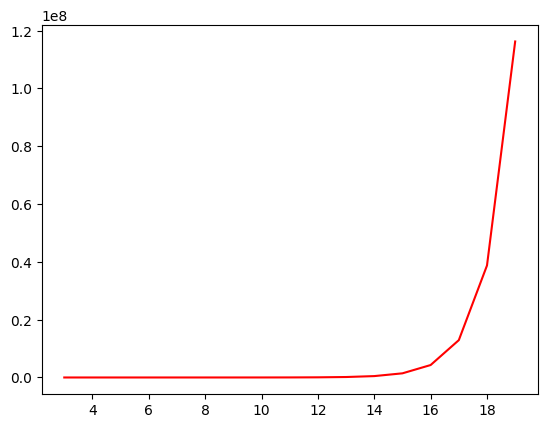

In [21]:
import scipy

k = 3
val = []
val_2 = []
x = []
for n in range(3, 20):
    val.append(k**n * 1/10)
    x.append(n)

plt.plot(x, val, c = 'red')
plt.show()